# ***Business understanding***

This project aims to analyze player performance in football using machine learning and statistical techniques. The ultimate goal is to identify top performers and predict positions based on their stats

Setting up the project

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import norm
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')


In [ ]:
# Load the dataset to inspect its structure
data = pd.read_csv ('dataset-2020-09-24.csv')

# Display the first few rows of the dataset to understand its structure
data.head()

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,34.0,26.0,17.0,28.0,375.0,489.0,2,0,0,NaN
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,NaN
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,NaN,NaN,NaN,NaN,NaN,NaN,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2,0,9,0.0


# **Data Understanding and Cleaning**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571 entries, 0 to 570
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    571 non-null    object 
 1   Jersey Number           563 non-null    float64
 2   Club                    571 non-null    object 
 3   Position                571 non-null    object 
 4   Nationality             570 non-null    object 
 5   Age                     570 non-null    float64
 6   Appearances             571 non-null    int64  
 7   Wins                    571 non-null    int64  
 8   Losses                  571 non-null    int64  
 9   Goals                   571 non-null    int64  
 10  Goals per match         309 non-null    float64
 11  Headed goals            502 non-null    float64
 12  Goals with right foot   502 non-null    float64
 13  Goals with left foot    502 non-null    float64
 14  Penalties scored        309 non-null    fl

In [ ]:
# Step 1: Separate categorical and numeric columns
categorical_cols = data.select_dtypes(include=['object']).columns
numeric_cols = data.select_dtypes(include=['number']).columns

# Step 2: Impute categorical columns with the mode
for col in categorical_cols:
    mode_value = data[col].mode()[0]  # Get the most frequent value
    data[col].fillna(mode_value, inplace=True)  # Fill missing values with the mode

# Step 3: Impute numeric columns with the median (to handle outliers)
for col in numeric_cols:
    median_value = data[col].median()  # Calculate the median
    data[col].fillna(median_value, inplace=True)  # Fill missing values with the median

# Step 4: Verify Missing Data Handling
remaining_missing = data.isnull().sum()  # Check for remaining missing values
if remaining_missing.sum() == 0:  # Sum the series to check if all are handled
    print("\nAll missing values have been handled!")
else:
    print(f"\nRemaining missing values per column:\n{remaining_missing}")


All missing values have been handled!


In [ ]:
#supprimer les doublons
data.drop_duplicates(inplace=True)

In [ ]:
# Drop columns with more than 50% missing values
threshold = 0.5 * len(data)
data_cleaned = data.dropna(thresh=threshold, axis=1)

In [ ]:
data.head()

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,Punches,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,34.0,26.0,17.0,28.0,375.0,489.0,2,0,0,2.0
1,Matt Macey,33.0,Arsenal,Goalkeeper,England,26.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2.0
2,Rúnar Alex Rúnarsson,13.0,Arsenal,Goalkeeper,Iceland,25.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,2.0
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,2.0,6.0,3.0,4.0,39.0,53.0,23,0,125,8.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,2.0,6.0,3.0,4.0,39.0,53.0,2,0,9,0.0


In [ ]:
print(data_cleaned['Position'].value_counts())

Position
Midfielder    198
Defender      194
Forward       110
Goalkeeper     69
Name: count, dtype: int64


# Creating performance metrics and normalizing data.

In [ ]:
# Define key performance metrics for different positions
metrics_by_position = {
    'Forward': ['Goals', 'Assists', 'Shots on target', 'Big chances created'],
    'Midfielder': ['Assists', 'Passes', 'Passes per match', 'Interceptions'],
    'Defender': ['Tackles', 'Clearances', 'Blocked shots', 'Duels won'],
    'Goalkeeper': ['Saves', 'Clean sheets', 'Goals conceded', 'Penalties saved']
}

In [ ]:
from sklearn.preprocessing import normalize

def calculate_performance(player_row, position):
    metrics = metrics_by_position.get(position, [])
    if not metrics:
        return 0  # No metrics are defined for the position

    score = 0
    for metric in metrics:
        if metric in player_row.index:
            # Normalize the column and extract the relevant value
            normalized_values = normalize(data_cleaned[[metric]].values)  # Ensure 2D input
            score += normalized_values[player_row.name, 0]  # Use the correct index for player_row
    return score

In [ ]:
# Add a performance score to each player based on their position
data_cleaned['Performance Score'] = data_cleaned.apply(lambda row: calculate_performance(row, row['Position']), axis=1)

In [ ]:
print(data_cleaned.head)

<bound method NDFrame.head of                      Name  Jersey Number                     Club    Position  \
0              Bernd Leno            1.0                  Arsenal  Goalkeeper   
1              Matt Macey           33.0                  Arsenal  Goalkeeper   
2    Rúnar Alex Rúnarsson           13.0                  Arsenal  Goalkeeper   
3         Héctor Bellerín            2.0                  Arsenal    Defender   
4          Kieran Tierney            3.0                  Arsenal    Defender   
..                    ...            ...                      ...         ...   
566            Pedro Neto            7.0  Wolverhampton-Wanderers     Forward   
567          Raúl Jiménez            9.0  Wolverhampton-Wanderers     Forward   
568          Adama Traoré           37.0  Wolverhampton-Wanderers     Forward   
569           Fábio Silva           17.0  Wolverhampton-Wanderers     Forward   
570      Leonardo Campana           30.0  Wolverhampton-Wanderers     Forward  

<Axes: xlabel='Performance Score'>

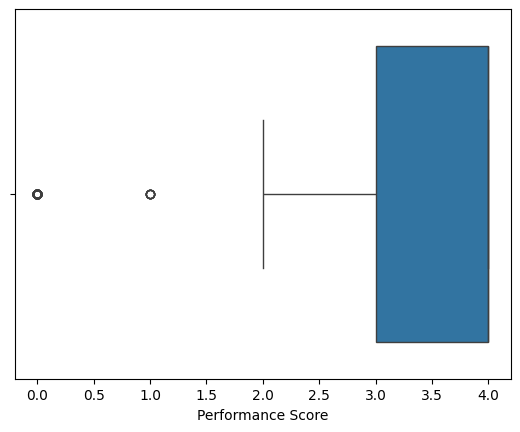

In [ ]:
#Handling the Outliers
sns.boxplot(x=data_cleaned['Performance Score'])

<Axes: xlabel='Age'>

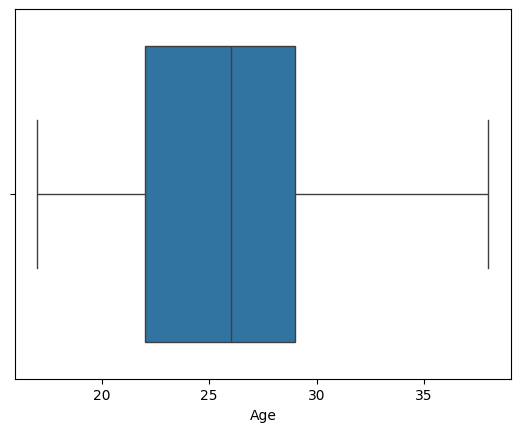

In [ ]:
sns.boxplot(x=data_cleaned['Age'])


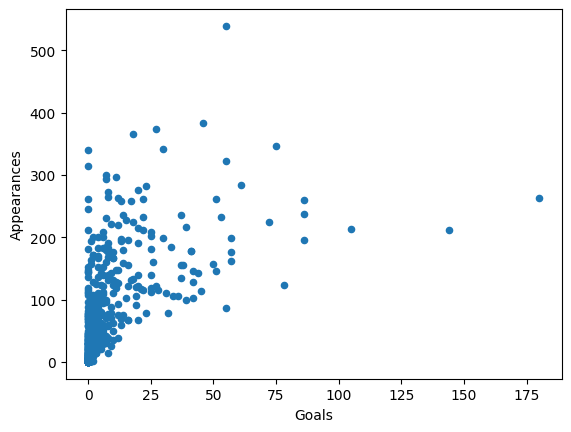

In [ ]:
aa = data_cleaned.plot.scatter(x='Goals', y='Appearances')

you have to interpret the outliers


In [ ]:
data_filtered= data_cleaned[data_cleaned['Appearances'] > 0]

In [ ]:
data_filtered.to_csv('data_filtered.csv', index=False)

In [ ]:
data_filtered

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,Performance Score
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,26.0,17.0,28.0,375.0,489.0,2,0,0,2.0,4.0
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,6.0,3.0,4.0,39.0,53.0,23,0,125,8.0,4.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,6.0,3.0,4.0,39.0,53.0,2,0,9,0.0,4.0
6,Sokratis,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,...,6.0,3.0,4.0,39.0,53.0,18,0,56,1.0,4.0
7,Rob Holding,16.0,Arsenal,Defender,England,25.0,41,25,9,0,...,6.0,3.0,4.0,39.0,53.0,8,0,32,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Vitinha,20.0,Wolverhampton-Wanderers,Midfielder,Portugal,20.0,1,1,0,0,...,6.0,3.0,4.0,39.0,53.0,0,0,0,0.0,2.0
566,Pedro Neto,7.0,Wolverhampton-Wanderers,Forward,Portugal,20.0,31,14,7,3,...,6.0,3.0,4.0,39.0,53.0,3,0,16,5.0,4.0
567,Raúl Jiménez,9.0,Wolverhampton-Wanderers,Forward,Mexico,29.0,78,32,23,32,...,6.0,3.0,4.0,39.0,53.0,7,0,81,52.0,4.0
568,Adama Traoré,37.0,Wolverhampton-Wanderers,Forward,Spain,24.0,105,27,47,5,...,6.0,3.0,4.0,39.0,53.0,4,0,80,13.0,4.0


In [ ]:
#Correlation
# Filtrer pour les colonnes numériques uniquement
numeric_data = data_filtered.select_dtypes(include=['float64', 'int64'])

In [ ]:
# Calculer la matrice de corrélation
correlation_matrix = numeric_data.corr()
# Afficher la matrice de corrélation
print(correlation_matrix)


                        Jersey Number       Age  Appearances      Wins  \
Jersey Number                1.000000 -0.249551    -0.244366 -0.206661   
Age                         -0.249551  1.000000     0.541025  0.465905   
Appearances                 -0.244366  0.541025     1.000000  0.934454   
Wins                        -0.206661  0.465905     0.934454  1.000000   
Losses                      -0.247531  0.534227     0.902561  0.696921   
Goals                       -0.160822  0.245598     0.549375  0.582485   
Goals per match              0.111078 -0.091484    -0.158912 -0.139596   
Headed goals                -0.144069  0.260730     0.448854  0.437724   
Goals with right foot       -0.139175  0.201247     0.496742  0.527588   
Goals with left foot        -0.124589  0.200102     0.405833  0.450776   
Penalties scored            -0.107237  0.176454     0.346969  0.345212   
Freekicks scored            -0.067062  0.145495     0.314166  0.294490   
Shots                       -0.172045 

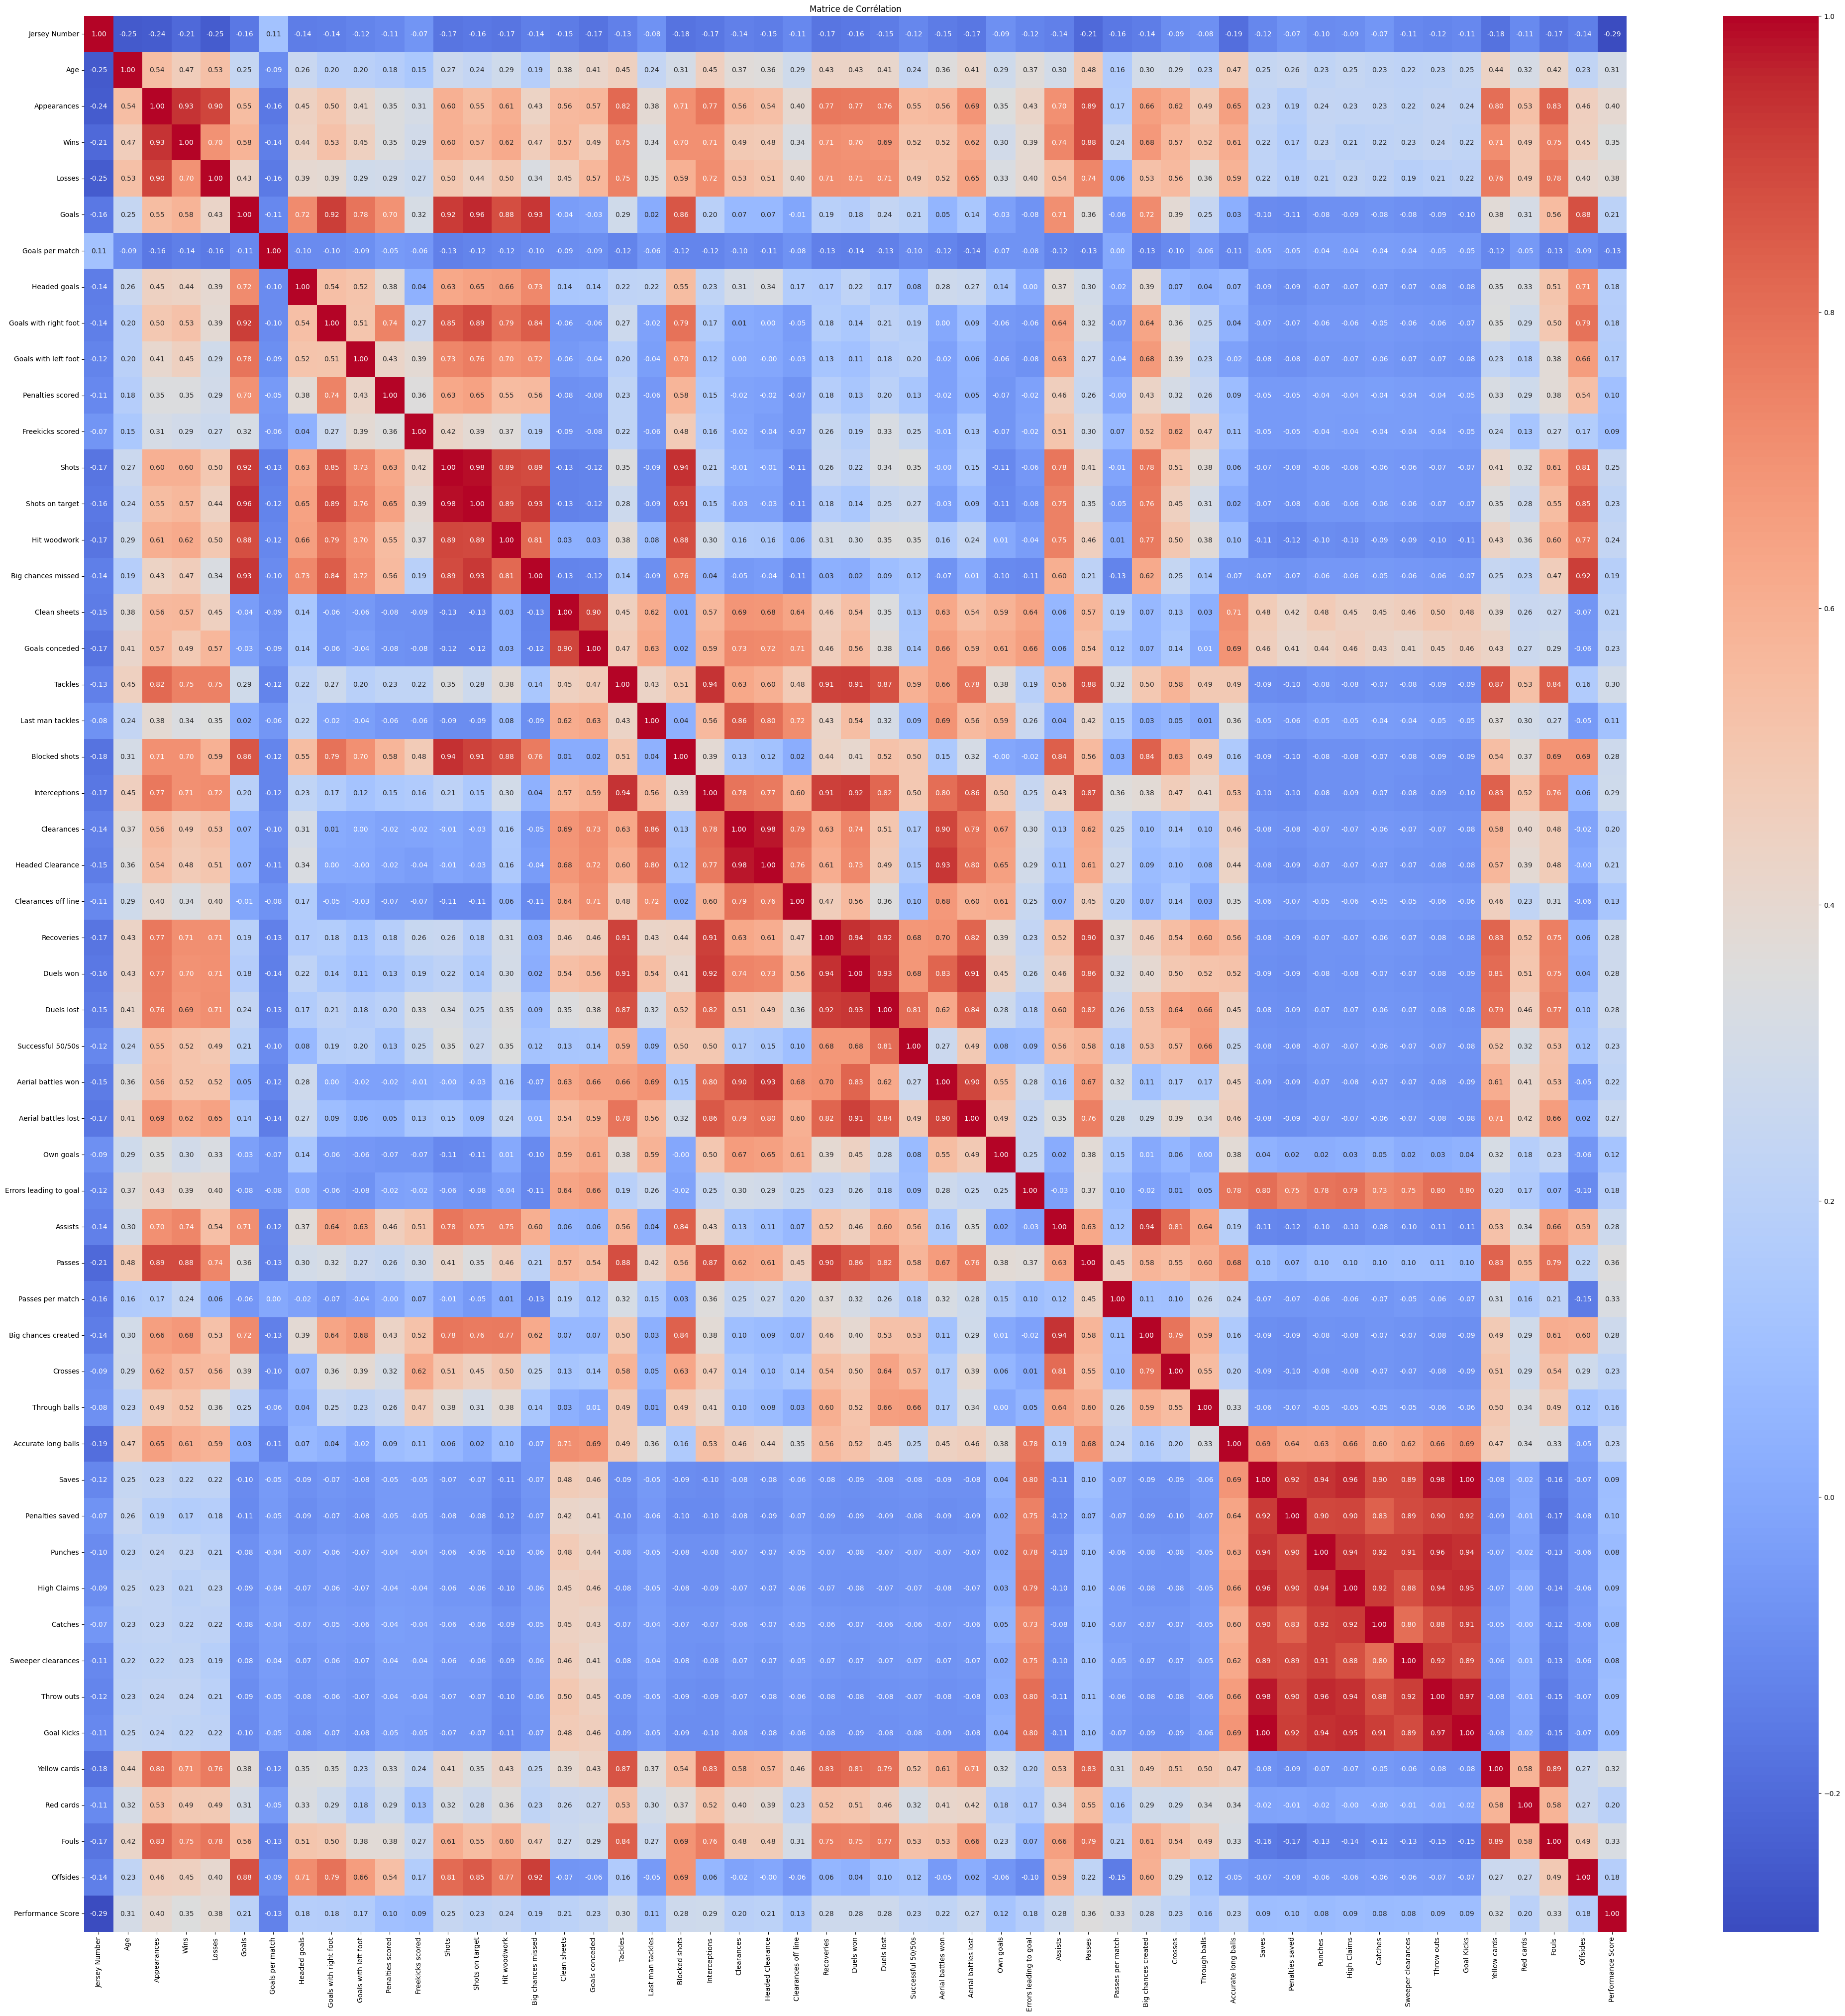

In [ ]:
# Visualiser la matrice de corrélation
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de Corrélation")
plt.show()

In [ ]:
top_players_by_position = data_filtered.groupby('Position').apply(lambda x: x.nlargest(3, 'Performance Score'))

In [ ]:
for position , players in top_players_by_position.groupby(top_players_by_position['Position']):
    print(f"\nMeilleurs joueurs pour la position {position} :")
    print(players[['Name', 'Club', 'Performance Score']])


Meilleurs joueurs pour la position Defender :
                       Name     Club  Performance Score
Position                                               
Defender 3  Héctor Bellerín  Arsenal                4.0
         4   Kieran Tierney  Arsenal                4.0
         6         Sokratis  Arsenal                4.0

Meilleurs joueurs pour la position Forward :
                                  Name     Club  Performance Score
Position                                                          
Forward  23        Alexandre Lacazette  Arsenal                4.0
         24  Pierre-Emerick Aubameyang  Arsenal                4.0
         25               Nicolas Pépé  Arsenal                4.0

Meilleurs joueurs pour la position Goalkeeper :
                            Name         Club  Performance Score
Position                                                        
Goalkeeper 0          Bernd Leno      Arsenal                4.0
           30         Tom Heaton  Aston-Villa   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra


In [ ]:
data_filtered.columns = data_filtered.columns.str.strip()

In [ ]:
data_filtered

,Name,Jersey Number,Club,Position,Nationality,Age,Appearances,Wins,Losses,Goals,...,High Claims,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,Performance Score
0,Bernd Leno,1.0,Arsenal,Goalkeeper,Germany,28.0,64,28,16,0,...,26.0,17.0,28.0,375.0,489.0,2,0,0,2.0,4.0
3,Héctor Bellerín,2.0,Arsenal,Defender,Spain,25.0,160,90,37,7,...,6.0,3.0,4.0,39.0,53.0,23,0,125,8.0,4.0
4,Kieran Tierney,3.0,Arsenal,Defender,Scotland,23.0,16,7,5,1,...,6.0,3.0,4.0,39.0,53.0,2,0,9,0.0,4.0
6,Sokratis,5.0,Arsenal,Defender,Greece,32.0,44,21,11,3,...,6.0,3.0,4.0,39.0,53.0,18,0,56,1.0,4.0
7,Rob Holding,16.0,Arsenal,Defender,England,25.0,41,25,9,0,...,6.0,3.0,4.0,39.0,53.0,8,0,32,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Vitinha,20.0,Wolverhampton-Wanderers,Midfielder,Portugal,20.0,1,1,0,0,...,6.0,3.0,4.0,39.0,53.0,0,0,0,0.0,2.0
566,Pedro Neto,7.0,Wolverhampton-Wanderers,Forward,Portugal,20.0,31,14,7,3,...,6.0,3.0,4.0,39.0,53.0,3,0,16,5.0,4.0
567,Raúl Jiménez,9.0,Wolverhampton-Wanderers,Forward,Mexico,29.0,78,32,23,32,...,6.0,3.0,4.0,39.0,53.0,7,0,81,52.0,4.0
568,Adama Traoré,37.0,Wolverhampton-Wanderers,Forward,Spain,24.0,105,27,47,5,...,6.0,3.0,4.0,39.0,53.0,4,0,80,13.0,4.0


In [ ]:
def add_position_code_column(data_filtered, position):

    # Initialiser une liste pour stocker les codes
    position_codes = []

    # Parcourir chaque ligne pour déterminer le code de la position
    for pos in data_filtered[position]:
        if pos == "Midfielder":
            position_codes.append(0)
        elif pos == "Defender":
            position_codes.append(1)
        elif pos == "Forward":
            position_codes.append(2)
        elif pos == "Goalkeeper":
            position_codes.append(3)
        else:
            position_codes.append(-1)  # Code par défaut pour les valeurs inconnues

    # Ajouter la nouvelle colonne au DataFrame
    data_filtered['PositionCode'] = position_codes

    return data_filtered

# Exemple d'utilisation
football = add_position_code_column(data_filtered, "Position")

# Affichage du résultat
print(football)


                Name  Jersey Number                     Club    Position  \
0         Bernd Leno            1.0                  Arsenal  Goalkeeper   
3    Héctor Bellerín            2.0                  Arsenal    Defender   
4     Kieran Tierney            3.0                  Arsenal    Defender   
6           Sokratis            5.0                  Arsenal    Defender   
7        Rob Holding           16.0                  Arsenal    Defender   
..               ...            ...                      ...         ...   
564          Vitinha           20.0  Wolverhampton-Wanderers  Midfielder   
566       Pedro Neto            7.0  Wolverhampton-Wanderers     Forward   
567     Raúl Jiménez            9.0  Wolverhampton-Wanderers     Forward   
568     Adama Traoré           37.0  Wolverhampton-Wanderers     Forward   
569      Fábio Silva           17.0  Wolverhampton-Wanderers     Forward   

    Nationality   Age  Appearances  Wins  Losses  Goals  ...  Catches  \
0       German

In [ ]:
features = ['Goals', 'Assists', 'Shots on target', 'Big chances created', 'Passes', 'Tackles']  # Example feature columns
target = 'PositionCode'

In [ ]:
df = data_filtered[features + [target]].dropna()
X = df[features]
y = df[target]


In [ ]:
X
y

,PositionCode
0,3
3,1
4,1
6,1
7,1
...,...
564,0
566,2
567,2
568,2


# Model Training and Evaluation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**K-Nearest Neighbors (KNN)**

In [ ]:
# Split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, test_size=0.2)


In [ ]:
print(X_train.shape)

(384, 6)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train, y_train)


KNeighborsClassifier()

In [ ]:
yhat = knn.predict(X_test)

In [ ]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.84375
Test set Accuracy:  0.7010309278350515


In [ ]:
Ks = 22
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.69072165, 0.62886598, 0.64948454, 0.65979381, 0.70103093,
       0.68041237, 0.70103093, 0.65979381, 0.64948454, 0.67010309,
       0.63917526, 0.65979381, 0.67010309, 0.68041237, 0.67010309,
       0.65979381, 0.68041237, 0.67010309, 0.67010309, 0.67010309,
       0.68041237])

In [ ]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7010309278350515 with k= 5


**Support Vector Machines (SVM)**

In [ ]:
from sklearn import metrics
from sklearn.svm import SVC
import numpy as np

# Train and evaluate the SVM model with a specific kernel (e.g., linear, rbf, poly, etc.)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
mean_acc = np.zeros(len(kernels))
std_acc = np.zeros(len(kernels))

# Loop through the kernels to find the best one
for i, kernel in enumerate(kernels):
    # Initialize the SVM model with the current kernel
    svm_clf = SVC(kernel=kernel).fit(X_train, y_train)

    # Predict the test set
    yhat = svm_clf.predict(X_test)

    # Compute accuracy for each kernel
    mean_acc[i] = metrics.accuracy_score(y_test, yhat)
    std_acc[i] = np.std(yhat == y_test) / np.sqrt(yhat.shape[0])

    # Print training and test accuracy for each kernel
    print(f"Train set Accuracy with {kernel} kernel: ", metrics.accuracy_score(y_train, svm_clf.predict(X_train)))
    print(f"Test set Accuracy with {kernel} kernel: ", mean_acc[i])

# Find and print the best kernel
print(f"The best accuracy was with {mean_acc.max():.2f} using the '{kernels[mean_acc.argmax()]}' kernel.")

Train set Accuracy with linear kernel:  0.5416666666666666
Test set Accuracy with linear kernel:  0.4742268041237113
Train set Accuracy with poly kernel:  0.4921875
Test set Accuracy with poly kernel:  0.38144329896907214
Train set Accuracy with rbf kernel:  0.6119791666666666
Test set Accuracy with rbf kernel:  0.4639175257731959
Train set Accuracy with sigmoid kernel:  0.4453125
Test set Accuracy with sigmoid kernel:  0.3711340206185567
The best accuracy was with 0.47 using the 'linear' kernel.


**Arbre de décision (ADD)**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Initialiser le modèle d'arbre de décision avec max_depth=8
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [ ]:
y_pred = tree_clf.predict(X_test)

# Calculer l'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"L'accuracy de l'arbre de décision est : {accuracy:.2f} with depth = 4")

L'accuracy de l'arbre de décision est : 0.88 with depth = 4


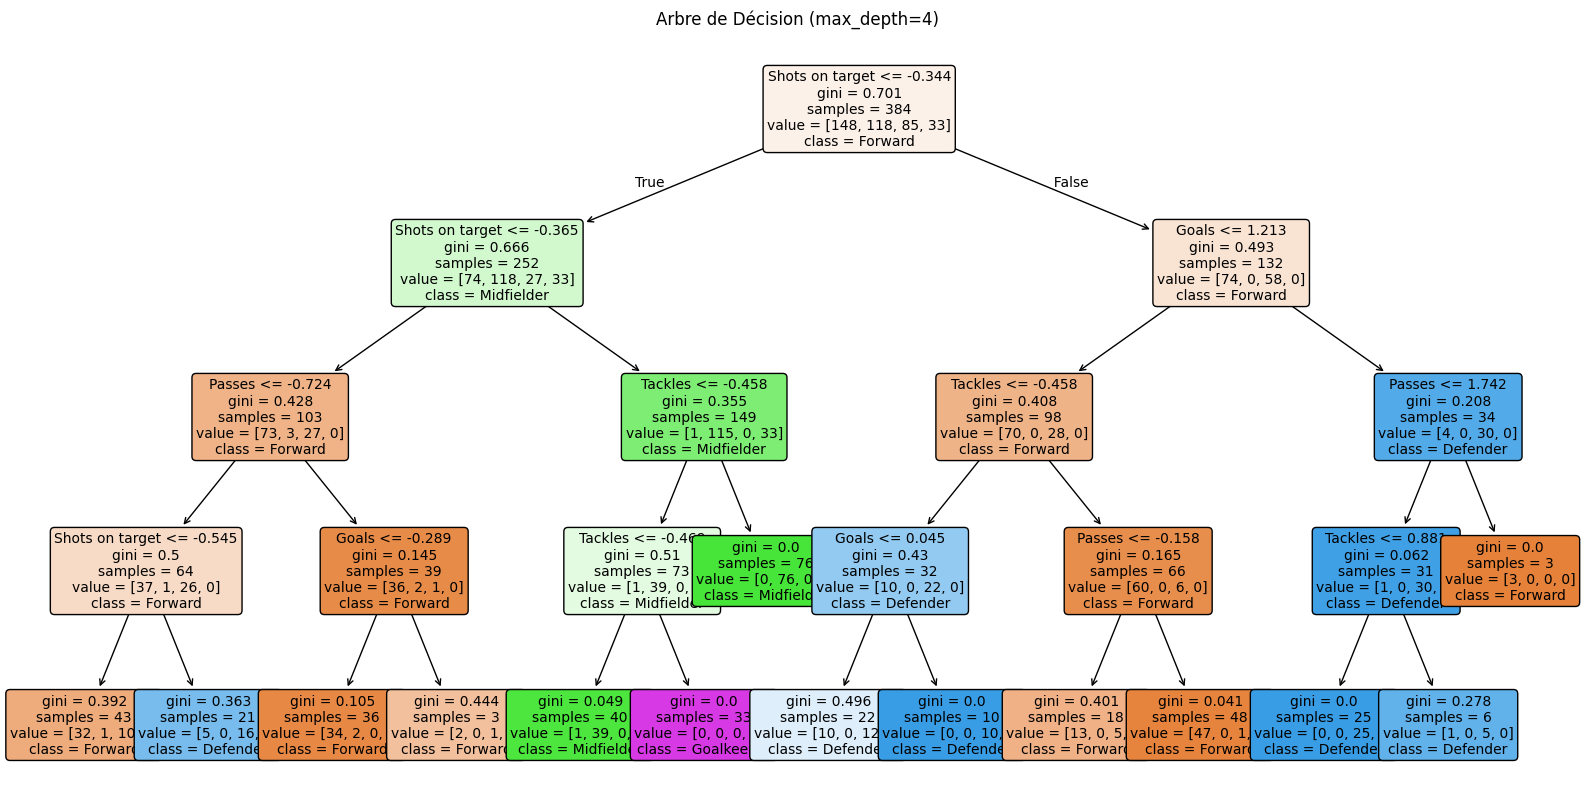

In [ ]:
from sklearn.tree import plot_tree
class_names = ['Forward', 'Midfielder', 'Defender','Goalkeeper']

plt.figure(figsize=(20, 10))
plot_tree(tree_clf,
          feature_names=features,
          class_names = class_names,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Arbre de Décision (max_depth=4)")
plt.show()

In [ ]:
# xgboost
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Train an XGBoost classifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [ ]:
# Evaluate
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))

XGBoost Accuracy: 0.845360824742268


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.865979381443299


In [ ]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 481 entries, 0 to 569
Data columns (total 61 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    481 non-null    object 
 1   Jersey Number           481 non-null    float64
 2   Club                    481 non-null    object 
 3   Position                481 non-null    object 
 4   Nationality             481 non-null    object 
 5   Age                     481 non-null    float64
 6   Appearances             481 non-null    int64  
 7   Wins                    481 non-null    int64  
 8   Losses                  481 non-null    int64  
 9   Goals                   481 non-null    int64  
 10  Goals per match         481 non-null    float64
 11  Headed goals            481 non-null    float64
 12  Goals with right foot   481 non-null    float64
 13  Goals with left foot    481 non-null    float64
 14  Penalties scored        481 non-null    float64

**K-means --> Clustering**

In [ ]:
List = [
    'Name',
    'Club',
    'Position',
    'Nationality',
    'Shooting accuracy %',
    'Tackle success %',
    'Cross accuracy %'
]

# Drop specified columns, ignoring any that are not found
for col in List:
    football = football.drop(col, axis=1, errors='ignore')

# Display the updated DataFrame
football

,Jersey Number,Age,Appearances,Wins,Losses,Goals,Goals per match,Headed goals,Goals with right foot,Goals with left foot,...,Catches,Sweeper clearances,Throw outs,Goal Kicks,Yellow cards,Red cards,Fouls,Offsides,Performance Score,PositionCode
0,1.0,28.0,64,28,16,0,0.14,0.0,1.0,0.0,...,17.0,28.0,375.0,489.0,2,0,0,2.0,4.0,3
3,2.0,25.0,160,90,37,7,0.14,0.0,4.0,3.0,...,3.0,4.0,39.0,53.0,23,0,125,8.0,4.0,1
4,3.0,23.0,16,7,5,1,0.14,0.0,0.0,1.0,...,3.0,4.0,39.0,53.0,2,0,9,0.0,4.0,1
6,5.0,32.0,44,21,11,3,0.14,1.0,2.0,0.0,...,3.0,4.0,39.0,53.0,18,0,56,1.0,4.0,1
7,16.0,25.0,41,25,9,0,0.14,0.0,0.0,0.0,...,3.0,4.0,39.0,53.0,8,0,32,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,20.0,20.0,1,1,0,0,1.00,0.0,0.0,0.0,...,3.0,4.0,39.0,53.0,0,0,0,0.0,2.0,0
566,7.0,20.0,31,14,7,3,0.10,0.0,1.0,2.0,...,3.0,4.0,39.0,53.0,3,0,16,5.0,4.0,2
567,9.0,29.0,78,32,23,32,0.41,9.0,19.0,4.0,...,3.0,4.0,39.0,53.0,7,0,81,52.0,4.0,2
568,37.0,24.0,105,27,47,5,0.05,0.0,5.0,0.0,...,3.0,4.0,39.0,53.0,4,0,80,13.0,4.0,2


In [ ]:
##ACP
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_num = scaler.fit_transform(data[numeric_cols])  # Use numeric columns only

In [ ]:
# Apply PCA
pca = PCA()

X_pca = pca.fit_transform(X_num)

In [ ]:
# Replace the scaled data with PCA-transformed data for model training
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [3.68910655e-01 1.95987144e-01 1.49275895e-01 6.03181484e-02
 2.46951548e-02 2.21142687e-02 1.92342985e-02 1.65356192e-02
 1.42030788e-02 1.22507070e-02 1.12880535e-02 1.09010232e-02
 1.02886430e-02 8.51461575e-03 7.32593604e-03 6.86720321e-03
 6.83699660e-03 6.01932401e-03 4.83602620e-03 4.43891180e-03
 4.08441155e-03 3.65977499e-03 3.54085237e-03 3.31585579e-03
 3.11657678e-03 2.37787077e-03 2.19526136e-03 2.00358271e-03
 1.81814338e-03 1.59714135e-03 1.34891800e-03 1.25063940e-03
 1.23218347e-03 9.88801197e-04 8.92190689e-04 8.29687347e-04
 8.05671282e-04 6.84582191e-04 5.72205957e-04 5.29120810e-04
 4.53745297e-04 4.15973867e-04 4.06075304e-04 2.83306726e-04
 2.38754303e-04 1.78559372e-04 1.35817457e-04 8.03456917e-05
 6.23120940e-05 3.17974671e-05 2.34386163e-05 4.69935478e-06]


In [ ]:
eig = pd.DataFrame({
    "Dimension": ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))],
    "Variance expliquée": pca.explained_variance_,
    "% variance expliquée": np.round(pca.explained_variance_ratio_ * 100, 2),
    "% cum. var. expliquée": np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2)
})

# Affichage du tableau
print(eig)

   Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0       Dim1           19.217009                 36.89                  36.89
1       Dim2           10.209211                 19.60                  56.49
2       Dim3            7.775965                 14.93                  71.42
3       Dim4            3.142046                  6.03                  77.45
4       Dim5            1.286401                  2.47                  79.92
5       Dim6            1.151959                  2.21                  82.13
6       Dim7            1.001938                  1.92                  84.05
7       Dim8            0.861361                  1.65                  85.71
8       Dim9            0.739856                  1.42                  87.13
9      Dim10            0.638154                  1.23                  88.35
10     Dim11            0.588009                  1.13                  89.48
11     Dim12            0.567848                  1.09          

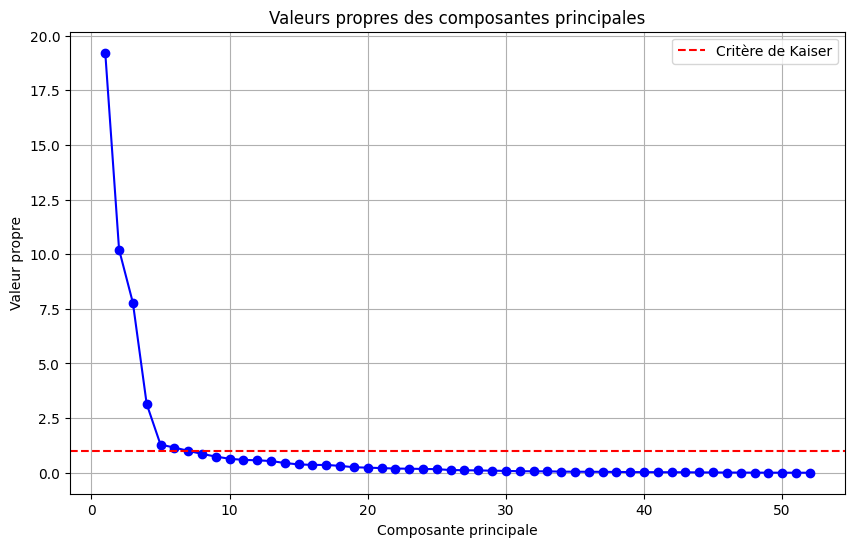

In [ ]:
# Valeurs propres (variance expliquée par chaque composante)
eigenvalues = pca.explained_variance_

# Trace du scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', color='b')
plt.axhline(y=1, color='r', linestyle='--', label='Critère de Kaiser')
plt.title("Valeurs propres des composantes principales")
plt.xlabel("Composante principale")
plt.ylabel("Valeur propre")
plt.legend()
plt.grid(True)
plt.show()

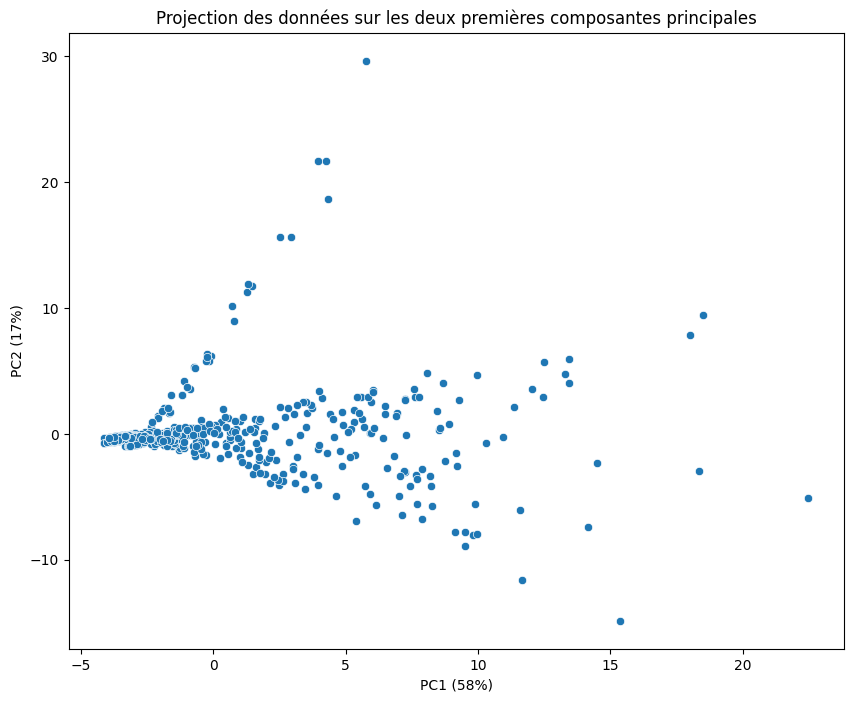

In [ ]:
# Création d'un DataFrame pour les deux premières composantes principales
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])

# Visualisation de la projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df)
plt.title('Projection des données sur les deux premières composantes principales')
plt.xlabel('PC1 (58%)')
plt.ylabel('PC2 (17%)')
plt.show()

In [ ]:
data_filtered.columns

Index(['Name', 'Jersey Number', 'Club', 'Position', 'Nationality', 'Age',
       'Appearances', 'Wins', 'Losses', 'Goals', 'Goals per match',
       'Headed goals', 'Goals with right foot', 'Goals with left foot',
       'Penalties scored', 'Freekicks scored', 'Shots', 'Shots on target',
       'Shooting accuracy %', 'Hit woodwork', 'Big chances missed',
       'Clean sheets', 'Goals conceded', 'Tackles', 'Tackle success %',
       'Last man tackles', 'Blocked shots', 'Interceptions', 'Clearances',
       'Headed Clearance', 'Clearances off line', 'Recoveries', 'Duels won',
       'Duels lost', 'Successful 50/50s', 'Aerial battles won',
       'Aerial battles lost', 'Own goals', 'Errors leading to goal', 'Assists',
       'Passes', 'Passes per match', 'Big chances created', 'Crosses',
       'Cross accuracy %', 'Through balls', 'Accurate long balls', 'Saves',
       'Penalties saved', 'Punches', 'High Claims', 'Catches',
       'Sweeper clearances', 'Throw outs', 'Goal Kicks', 'Yellow 

In [ ]:

# Grouper les joueurs par club et calculer la somme des scores de performance et le nombre de joueurs
club_performance = data_filtered.groupby('Club').agg(
    Total_Performance_Score=('Performance Score', 'sum'),  # Somme des scores de performance
    Player_Count=('Name', 'count')  # Nombre de joueurs
).reset_index()
# Rename columns for better readability
club_performance.columns = ['Club', 'Total Performance Score','NB']

# Display the result
print(club_performance)

                        Club  Total Performance Score  NB
0                    Arsenal                    101.0  27
1                Aston-Villa                     91.0  26
2   Brighton-and-Hove-Albion                     77.0  21
3                    Burnley                     73.0  20
4                    Chelsea                     90.0  24
5             Crystal-Palace                     90.0  25
6                    Everton                    106.0  29
7                     Fulham                     76.0  23
8               Leeds-United                     48.0  15
9             Leicester-City                    108.0  29
10                 Liverpool                     98.0  28
11           Manchester-City                     87.0  24
12         Manchester-United                    117.0  30
13          Newcastle-United                    106.0  27
14          Sheffield-United                     78.0  21
15               Southampton                     84.0  22
16         Tot

In [ ]:
club_performance.to_csv('club_performance.csv', index=False)

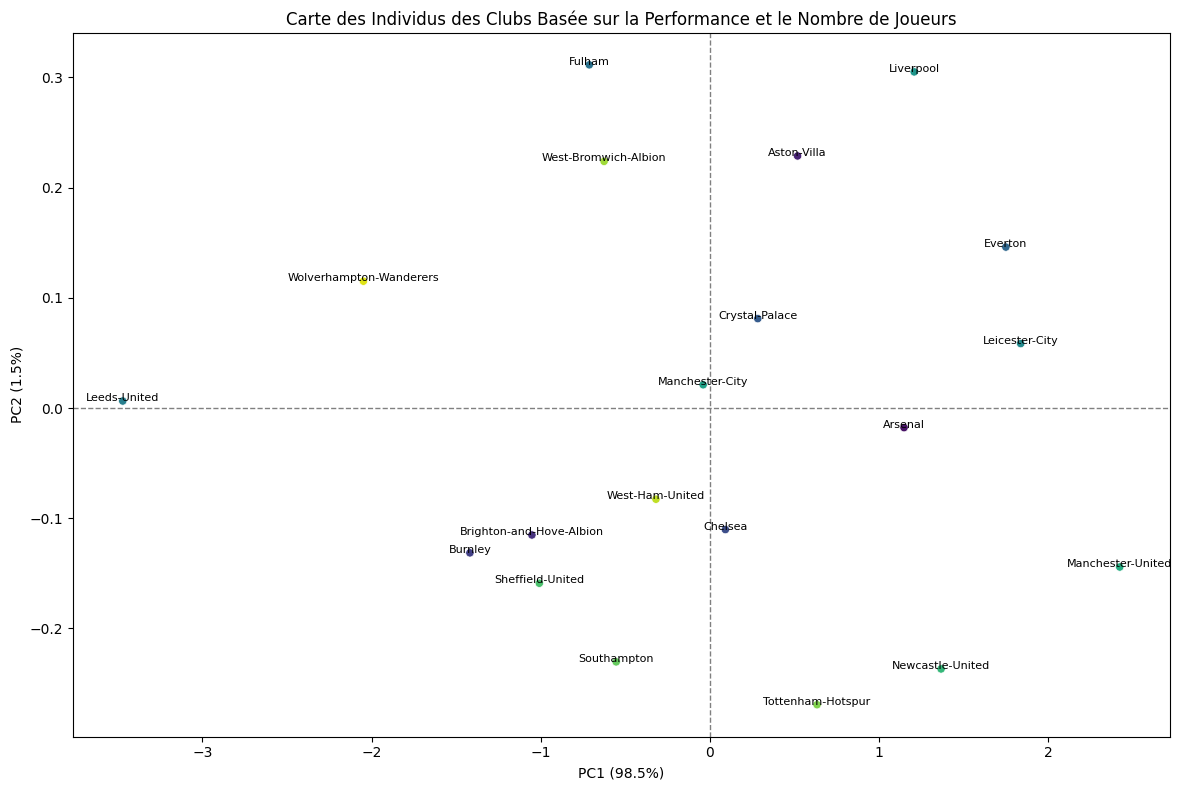

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Normalisation des colonnes 'Total Performance Score' et 'NB'
scaler = StandardScaler()
X_scaled = scaler.fit_transform(club_performance[['Total Performance Score', 'NB']])

# Application de la PCA avec 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame pour les résultats de la PCA
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Club'] = club_performance['Club']

# Visualisation des résultats
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue='Club', legend=None, palette="viridis")

# Tracer des axes centraux
plt.axhline(0, color='grey', linewidth=1, linestyle='--')
plt.axvline(0, color='grey', linewidth=1, linestyle='--')

# Ajout des noms des clubs sur le graphique
for i in range(pca_df.shape[0]):
    plt.text(x=pca_df['PC1'][i], y=pca_df['PC2'][i], s=pca_df['Club'][i],
             fontdict=dict(color='black', size=8), horizontalalignment='center')

# Titres et labels des axes
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.title("Carte des Individus des Clubs Basée sur la Performance et le Nombre de Joueurs")

plt.tight_layout()
plt.show()


In [ ]:
print(club_performance.isna().sum())


Club                       0
Total Performance Score    0
NB                         0
dtype: int64


In [ ]:
#import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
#from sklearn.datasets import make_blobs
%matplotlib inline

In [ ]:
# create a new dataframe X_clust droping the label to be be used later in the segmentation task using the kmeans
X_clust = football.drop(columns= target, axis=1)

# Display the new DataFrame
print(X_clust.head())

   Jersey Number   Age  Appearances  Wins  Losses  Goals  Goals per match  \
0            1.0  28.0           64    28      16      0             0.14   
3            2.0  25.0          160    90      37      7             0.14   
4            3.0  23.0           16     7       5      1             0.14   
6            5.0  32.0           44    21      11      3             0.14   
7           16.0  25.0           41    25       9      0             0.14   

   Headed goals  Goals with right foot  Goals with left foot  ...  \
0           0.0                    1.0                   0.0  ...   
3           0.0                    4.0                   3.0  ...   
4           0.0                    0.0                   1.0  ...   
6           1.0                    2.0                   0.0  ...   
7           0.0                    0.0                   0.0  ...   

   High Claims  Catches  Sweeper clearances  Throw outs  Goal Kicks  \
0         26.0     17.0                28.0       3

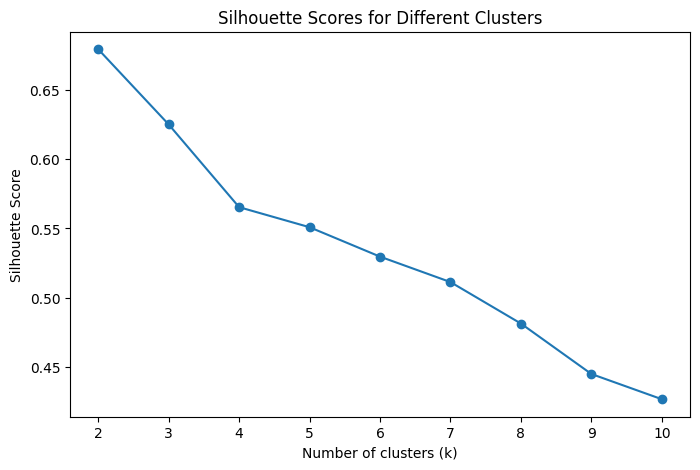

In [ ]:
# here We used the Silhouette coefficient metric to check if k=5 will result in a good quality of clustering.
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_clust)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_clust, labels))

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [ ]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum)
k_means.fit(X)

KMeans(n_clusters=4)

In [ ]:
labels = k_means.labels_
print(labels)

[0 1 0 3 3 1 1 2 3 0 2 3 3 3 0 3 0 1 0 0 3 3 0 0 0 0 1 3 0 0 0 1 0 3 0 0 1
 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 3 0 0 1 3 0 0 3 0 0 3 1 3 3 0 0 0 0 0 0 0
 3 0 1 3 3 1 1 1 0 0 2 0 0 0 3 2 0 3 3 0 3 0 1 1 3 1 0 2 0 0 3 1 1 1 3 3 0
 0 0 0 0 0 3 0 3 0 1 1 1 1 1 2 3 0 1 0 1 3 3 2 2 0 0 3 3 1 3 0 0 3 3 3 1 3
 3 1 0 0 1 1 3 0 3 0 0 0 1 0 0 3 3 0 1 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 1 0 0 0 3 3 2 0 3 3 0 0
 3 3 3 1 0 0 0 0 1 0 0 0 3 0 0 3 0 0 3 3 2 3 1 1 1 0 3 1 2 0 2 3 0 0 0 0 3
 0 1 1 3 0 0 0 0 3 3 1 2 1 3 3 3 0 1 0 0 1 3 1 3 2 0 0 0 1 3 1 1 1 0 0 0 3
 0 1 1 1 3 0 1 0 3 0 0 1 2 3 0 3 0 0 2 3 0 3 3 0 0 3 0 1 3 0 3 0 1 3 3 0 0
 1 3 3 0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 3 0 0 0 0 0 3
 0 3 0 3 1 0 3 0 0 0 1 1 0 0 1 0 0 3 3 0 0 1 0 1 2 3 0 3 1 0 3 3 3 1 1 0 1
 0 0 1 0 0 3 3 0 3 0 0 0 1 0 0 0 0 0 2 1 3 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0
 3 3 0 3 0 3 1 3 2 0 1 3 0 3 0 0 0 0 0 3 3 3 3 0 0 0 0 3 0 3 3 3 0 0 3 0 0]


In [ ]:
# Get the cluster centers
centers = k_means.cluster_centers_
print("Cluster Centers:\n", centers)

Cluster Centers:
 [[2.53281853e+00 1.58301158e+00 1.22393822e+01 2.47490347e+00
  5.86193050e+02 2.92895753e+01]
 [1.86710526e+01 1.46315789e+01 5.59473684e+01 2.11578947e+01
  6.90060526e+03 2.62578947e+02]
 [2.10000000e+01 2.46000000e+01 4.91000000e+01 2.57500000e+01
  1.28177000e+04 4.97650000e+02]
 [1.34047619e+01 7.96825397e+00 4.29761905e+01 1.17142857e+01
  3.06521429e+03 1.21555556e+02]]


In [ ]:
# Get the inertia (sum of squared distances to the nearest cluster center)
inertia = k_means.inertia_
print("Inertia:", inertia)

Inertia: 446904718.14869726


In [ ]:
# silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.6168722475193957


In [ ]:
#df["Clus_km"] = labels
#df.head(5)

In [ ]:
football.to_csv('football.csv', index=False)

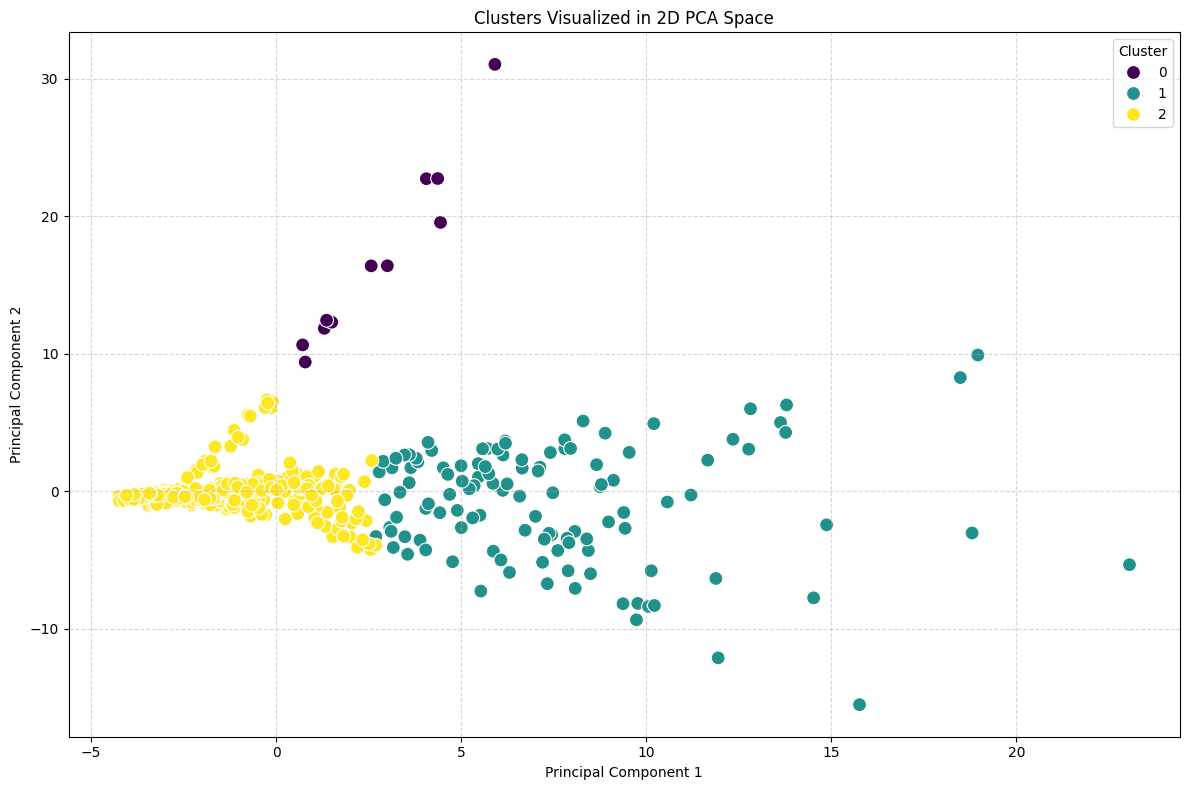

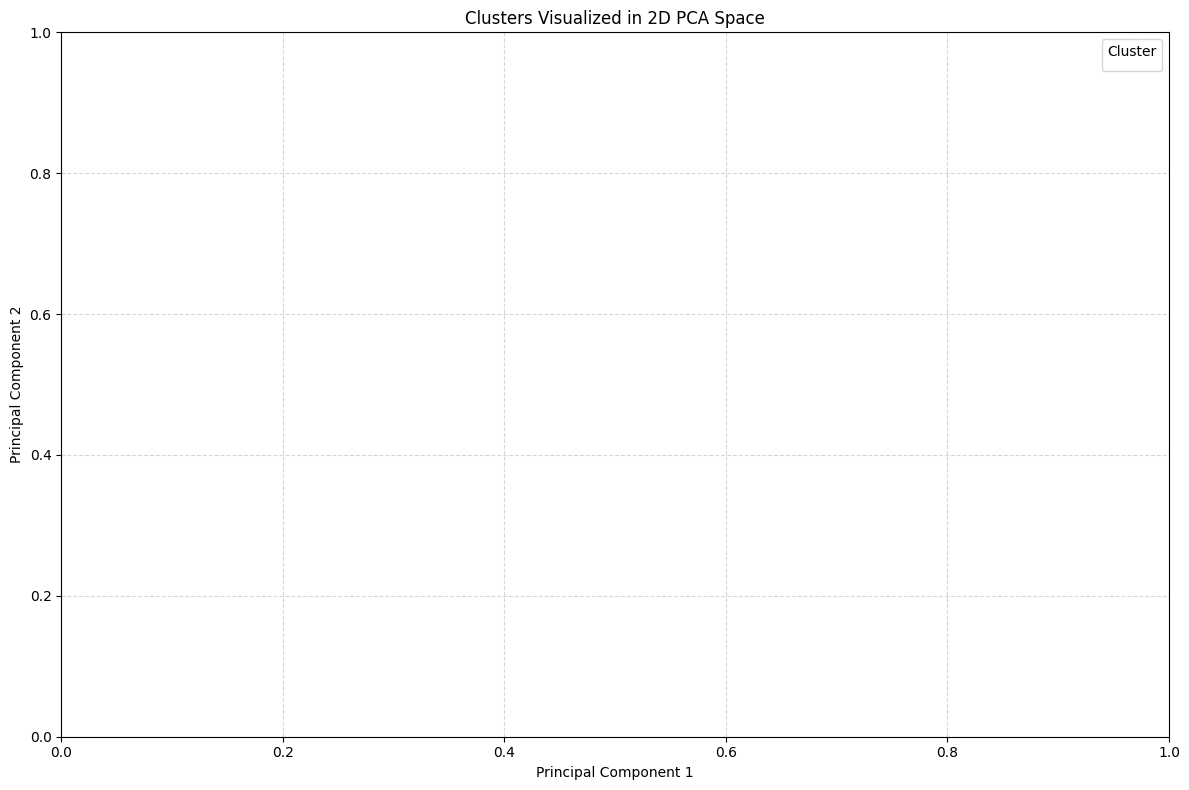

In [ ]:
# Visualisation des clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=data,  # Passez le DataFrame complet ici
    palette='viridis',
    s=100
)
plt.title("Clusters Visualized in 2D PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='upper right')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Example with 3 clusters
data['football'] = kmeans.fit_predict(data_scaled)

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PC1'] = data_pca[:, 0]
data['PC2'] = data_pca[:, 1]

# Visualize the clusters
plt.figure(figsize=(12, 8))

plt.title("Clusters Visualized in 2D PCA Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='upper right')
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()